# Chapter 11. 심층 신경망 훈련하기

# 기본 설정

In [1]:
#!pip install tensorflow

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 11.1 그레이디언트 소실과 폭주 문제

- **그레이디언트 소실**: 알고리즘이 하위층으로 진행될수록 그레이디언트는 점점 작아지는데, 이때 하위층의 연결 가중치를 변경하지 않은 채로 두면 훈련이 좋은 솔루션으로 수렴되지 않는 현상
- **그레이디언트 폭주**: 그레이디언트가 점점 커져서 여러 층이 비정상적으로 큰 가중치로 갱신되어 알고리즘이 발산(diverse)하는 현상

In [2]:
# 로지스틱 함수 정의
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


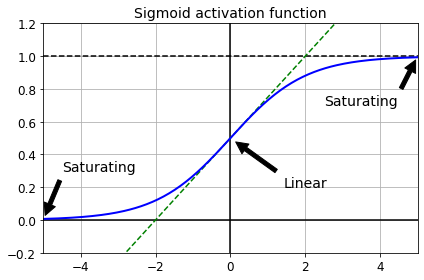

In [3]:
# [그림 11-1] 그래프를 작성하는 코드
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## 11.1.1 글로럿과 He 초기화


|초기화 전략|활성화 함수|정규분포|
|-------|----------------------------------------|------|
|글로럿|활성화 함수 없음, 하이퍼볼릭 탄젠트, 로지스틱, 소프트맥스|1/fan_(avg)|
|He|ReLU 함수와 그 변종들|2/fan_(in)|
|르쿤|SELU|1/fan_(in)|

In [4]:
# 케라스의 initializer 목록
[name for name in dir(keras.initializers) if not name.startswith('_')]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
# 층을 만들때 He 초기화 사용법
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

In [6]:
# fan_(in) 대신 fan_(out) 기반 균등분포 He 초기화 사용법
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg',
                                                distribution='uniform')
keras.layers.Dense(10, activation='relu', kernel_initializer=he_avg_init)

## 11.1.2 수렴하지 않는 활성화 함수

글로럿&벤지오의 2010년 논문에서 얻은 통찰 중 하나: **활성화 함수를 잘못 선택**하면 자칫 그레이디언트의 솟ㄹ이나 폭주로 이어질 수 있다는 것  

시그모이드 활성화 함수보다 ReLU 활성화 함수가 특정 양숫값에 수렴하지 않는다는 큰 장점이 있지만, ReLU 함수도 완벽하지 않음(죽은 ReLU 문제: 입력의 가중치 합이 음수가 되면 뉴런이 죽는 현상)  

이 문제를 해결하기 위해 **LeakyReLU** 같은 ReLU 함수의 변종을 사용함

### LeakyReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


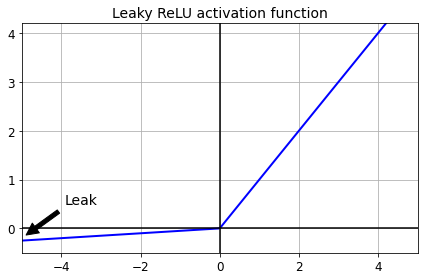

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

### ELU

In [20]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


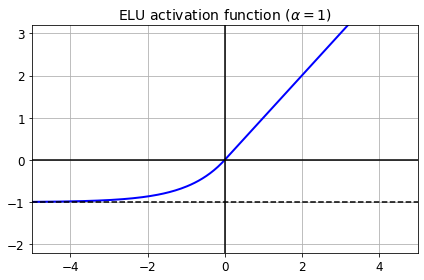

In [21]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [22]:
# 텐서플로에서 ELU 적용방법
keras.layers.Dense(10, activation='elu')

### SELU  
스케일이 조정된 ELU 활성화 함수의 변종

In [23]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화
# SELU는 이 자기 정규화가 깨지면 다른 활성화 함수보다 더 나은 성능을 내지 않을 것임
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [25]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha) # 앞서 정의한 elu 함수에 스케일링만 조정

그림 저장: selu_plot


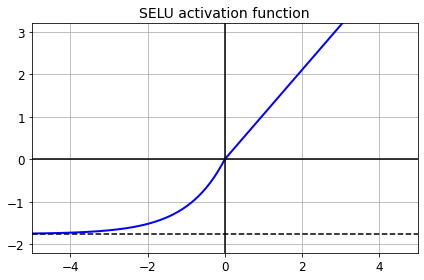

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

SELU 활성화 함수를 사용하면 1000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준편차를 1로 유지함. 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있음(아래 코드로 확인):

In [27]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [28]:
# 텐서플로에서 ELU 적용방법
keras.layers.Dense(10, activation='selu',
                  kernel_initializer='lecun_normal')

In [9]:
# 케라스의 활성화 함수 목록
[m for m in dir(keras.activations) if not m.startswith('_')]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
# 케라스의 ReLU 계열 활성화 함수 목록
[m for m in dir(keras.layers) if 'relu' in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
# LeakyReLU 활성화 함수를 사용하여 모델링
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(), # LeakyReLU는 이렇게 따로 층을 추가하여 사용
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [13]:
# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.3011 - accuracy: 0.6071 - val_loss: 0.8806 - val_accuracy: 0.7288
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7875 - accuracy: 0.7526 - val_loss: 0.7047 - val_accuracy: 0.7748
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6731 - accuracy: 0.7832 - val_loss: 0.6389 - val_accuracy: 0.7890
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6140 - accuracy: 0.8005 - val_loss: 0.5852 - val_accuracy: 0.8098
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5760 - accuracy: 0.8113 - val_loss: 0.5534 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5486 - accuracy: 0.8171 - val_loss: 0.5316 - val_accuracy: 0.8256
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5280 - accuracy: 0.8232 - val_loss: 0.5131 - val_accuracy:

PReLU로도 신경망 훈련 시도:

In [15]:
# PReLU 활성화 함수를 사용하여 모델링
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.PReLU(), # PReLU도 이렇게 따로 층을 추가하여 사용
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [16]:
# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.3073 - accuracy: 0.6081 - val_loss: 0.8833 - val_accuracy: 0.7240
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7989 - accuracy: 0.7367 - val_loss: 0.7109 - val_accuracy: 0.7674
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6852 - accuracy: 0.7733 - val_loss: 0.6412 - val_accuracy: 0.7914
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6237 - accuracy: 0.7946 - val_loss: 0.5863 - val_accuracy: 0.8114
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5833 - accuracy: 0.8059 - val_loss: 0.5522 - val_accuracy: 0.8190
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5543 - accuracy: 0.8138 - val_loss: 0.5282 - val_accuracy: 0.8258
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5324 - accuracy: 0.8209 - val_loss: 0.5080 - val_accuracy:

SELU로도 신경망 훈련 시도

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation='selu', # SELU는 activation에 적용하여 사용
                       kernel_initializer='lecun_normal'))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation='selu', 
                       kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [30]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [31]:
# 훈련 전 입력을 평균:0, 표준편차:1로 반드시 바꾸어야 함
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [32]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 28s 14ms/step - loss: 1.6555 - accuracy: 0.3380 - val_loss: 1.1570 - val_accuracy: 0.5096
Epoch 2/5
1719/1719 [==============================] - 24s 14ms/step - loss: 1.1848 - accuracy: 0.5354 - val_loss: 0.9325 - val_accuracy: 0.6446
Epoch 3/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.9187 - accuracy: 0.6390 - val_loss: 0.8178 - val_accuracy: 0.6886
Epoch 4/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.8392 - accuracy: 0.6758 - val_loss: 0.7925 - val_accuracy: 0.6862
Epoch 5/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.8169 - accuracy: 0.6856 - val_loss: 0.8839 - val_accuracy: 0.6450


SELU 말고 기존에 쓰던 ReLU를 다시 사용하여 결과 비교:

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [34]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [35]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 16ms/step - loss: 1.9974 - accuracy: 0.2145 - val_loss: 1.6495 - val_accuracy: 0.3366
Epoch 2/5
1719/1719 [==============================] - 25s 15ms/step - loss: 1.5331 - accuracy: 0.3930 - val_loss: 1.3760 - val_accuracy: 0.4142
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.0511 - accuracy: 0.5769 - val_loss: 1.8123 - val_accuracy: 0.2850
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.0749 - accuracy: 0.5857 - val_loss: 1.6627 - val_accuracy: 0.3910
Epoch 5/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.1000 - accuracy: 0.5729 - val_loss: 0.9525 - val_accuracy: 0.6672


loss가 줄어들다가 다시 커지는 것을 보니 그레이디언트 폭주나 소실 문제가 발생했다고 판단할 수 있음

## 11.1.3 배치 정규화

**배치 정규화(BN)**: 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산 하나를 추가하여 결과값의 스케일을 조정하고 이동시키는 기법  
훈련 동안 배치 정규화는 입력을 정규화한 다음 스케일을 조정하고 이동시킴  
많은 경우 배치 정규화를 신경망의 첫 번째 층으로 추가하여 사용하면 훈련 세트를 표준화할 필요가 없음   

그러나 배치 정규화는 모델의 복잡도를 키우고, 실행 시간 면에서도 손해이며, 층마다 추가되는 계산으로 인해 신경망의 예측을 느리게 한다는 단점이 있음(다행히 훈련이 끝난 후에 이전 층과 배치 정규화 층을 합쳐 실행 속도 저하를 피할 수는 있음)

### 케라스로 배치 정규화 구현하기

In [36]:
# 은닉층의 활성화 함수 전이나 후에 BatchNormalization 층을 추가하면 됨
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

마지막 두개의 파라미터는 이동 평균(뮤, 시그마)으로, 이 파라미터는 역전파로 학습되지 않기 때문에 케라스는 Non-trainable params로 분류함  
배치 정규화 파라미터의 전체 개수: (3136+1200+400) / 2 = 2368

In [38]:
# 첫 번째 배치 정규화 층의 파라미터
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

위 출력을 통해 케라스에서 배치 정규화 층을 만들 때, 훈련하는 동안 매 반복마다 케라스에서 호출될 두 개의 연산이 함께 생성되고 있음을 볼 수 있음

In [39]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8537 - accuracy: 0.7180 - val_loss: 0.5497 - val_accuracy: 0.8192
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5730 - accuracy: 0.8008 - val_loss: 0.4706 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5155 - accuracy: 0.8201 - val_loss: 0.4378 - val_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4757 - accuracy: 0.8331 - val_loss: 0.4171 - val_accuracy: 0.8572
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4504 - accuracy: 0.8417 - val_loss: 0.4009 - val_accuracy: 0.8630
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4341 - accuracy: 0.8469 - val_loss: 0.3901 - val_accuracy: 0.8674
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4189 - accuracy: 0.8508 - val_loss: 0.3808 - val_accuracy

활성화 함수 전에 BN을 적용해도 잘 동작한다고 했지만 여기에는 논란의 여지가 있음  
따라서 두 가지 방법 모두 실험해보고 어떤 것이 주어진 데이터셋에 가장 잘 맞는지 확인하는 것이 좋으므로 **활성화 함수 전에 배치 정규화 층을 추가**하여 다시 모델링해보겠음  

활성화 함수 전에 배치 정규화 층을 추가하려면 은닉층에서 활성화 함수를 지정하지 말고 **배치 정규화 층 뒤에 별도의 층으로 추가**해야 함  
또한 배치 정규화 층은 입력마다 이동 파라미터를 포함하기 때문에 이전 층에서 편향을 뺄 수 있음(층을 만들 때 `use_bias=False`로 설정)

In [41]:
# 활성화 함수 전에 배치 정규화 층을 추가하여 모델링
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False), # 위에서 설명한 부분
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'), # 위에서 설명한 부분
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [42]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.0407 - accuracy: 0.6740 - val_loss: 0.6753 - val_accuracy: 0.7900
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6795 - accuracy: 0.7797 - val_loss: 0.5567 - val_accuracy: 0.8192
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5992 - accuracy: 0.8022 - val_loss: 0.5016 - val_accuracy: 0.8400
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5473 - accuracy: 0.8175 - val_loss: 0.4676 - val_accuracy: 0.8454
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5133 - accuracy: 0.8261 - val_loss: 0.4430 - val_accuracy: 0.8490
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4906 - accuracy: 0.8322 - val_loss: 0.4243 - val_accuracy: 0.8566
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4743 - accuracy: 0.8383 - val_loss: 0.4096 - val_accuracy

## 11.1.4 그레이디언트 클리핑

**그레이디언트 클리핑(gradient clipping)**: 역전파 시 일정 임곗값을 넘어서지 못하게 그레이디언트를 잘라내어 그레이디언트 폭주 문제를 완화하는 방법

In [44]:
# 그레이디언트 클리핑 사용 방법
optimizer = keras.optimizers.SGD(clipvalue=1.0) # 옵티마이저에 매개변수로 지정하면 됨

In [45]:
# 그레이디언트 클리핑이 그레이디언트 벡터의 방향을 바꾸지 못하게 하려면
# 그레이디언트 노름을 사용함
optimizer = keras.optimizers.SGD(clipnorm=1.0) 

# 11.2 사전 훈련된 층 재사용하기

**전이 학습(transfer learning)**:해결하고자 하는 것과 비슷한 유형의 문제를 처리한 신경망이 있는지 찾아본 다음, 그 신경망의 하위층을 재사용하는 학습 방법  
이 방법은 훈련 속도를 크게 높일 뿐만 아니라  필요한 훈련 데이터도 크게 줄여줌 

## 11.2.1 케라스를 사용한 전이 학습  

In [2]:
# 앞에서 사용한 패션 MNIST 훈련 세트 다시 로드
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

패션 MNIST 훈련 세트를 두 개로 나눔:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트  

검증 세트와 테스트 세트도 이렇게 나눔 BUT 이미지 개수는 제한하지 않음  

A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 보겠음

In [3]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # 샌달 or 셔츠만 분리
    y_A = y[~y_5_or_6] # 샌달 or 셔츠를 전체 y에서 제외
    y_A[y_A > 6] -= 2 # 7,8,9를 의미했던 클래스를 5,6,7로 바꿔주어야 함
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # 이진 분류 데이터로 변경: 셔츠(클래스6)
    return ((X[~y_5_or_6], y_A), (X[y_5_or_6], y_B))

# train, valid, test 데이터를 모두 A,B로 나눔
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

# B 세트는 처음 200개만 가졌다고 했으므로 다시 줄여줌
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [4]:
# 분리 후 A 훈련 세트 확인
X_train_A.shape

(43986, 28, 28)

In [5]:
# 분리 후 B 훈련 세트 확인
X_train_B.shape

(200, 28, 28)

In [6]:
# A 훈련 세트 레이블이 잘 변경되었는지 확인
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [7]:
# B 훈련 세트 레이블이 잘 변경되었는지 확인
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

모델 A부터 설계 후 저장

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [9]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [10]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.6202 - accuracy: 0.8036 - val_loss: 0.3996 - val_accuracy: 0.8612
Epoch 2/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3644 - accuracy: 0.8750 - val_loss: 0.3345 - val_accuracy: 0.8847
Epoch 3/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.3206 - accuracy: 0.8877 - val_loss: 0.3027 - val_accuracy: 0.8964
Epoch 4/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2987 - accuracy: 0.8954 - val_loss: 0.2880 - val_accuracy: 0.9013
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2844 - accuracy: 0.9012 - val_loss: 0.2785 - val_accuracy: 0.9048
Epoch 6/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2742 - accuracy: 0.9052 - val_loss: 0.2753 - val_accuracy: 0.9058
Epoch 7/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2654 - accuracy: 0.9082 - val_loss: 0.2731 - val_accuracy:

In [15]:
model_A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 8)                 4

In [11]:
model_A.save("my_model_A.h5")

모델 B도 마찬가지로 설계 후 저장

In [12]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [13]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [14]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 77ms/step - loss: 0.7592 - accuracy: 0.5650 - val_loss: 0.5288 - val_accuracy: 0.7465
Epoch 2/20
7/7 [==============================] - 0s 24ms/step - loss: 0.4325 - accuracy: 0.8600 - val_loss: 0.4139 - val_accuracy: 0.8540
Epoch 3/20
7/7 [==============================] - 0s 27ms/step - loss: 0.3413 - accuracy: 0.9250 - val_loss: 0.3495 - val_accuracy: 0.8996
Epoch 4/20
7/7 [==============================] - 0s 24ms/step - loss: 0.2851 - accuracy: 0.9400 - val_loss: 0.3047 - val_accuracy: 0.9168
Epoch 5/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2447 - accuracy: 0.9550 - val_loss: 0.2722 - val_accuracy: 0.9331
Epoch 6/20
7/7 [==============================] - 0s 23ms/step - loss: 0.2143 - accuracy: 0.9550 - val_loss: 0.2455 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 30ms/step - loss: 0.1901 - accuracy: 0.9600 - val_loss: 0.2260 - val_accuracy: 0.9483
Epoch 8/20
7/7 [===========

In [16]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 1)                

먼저 모델 A를 로드하고 이 모델의 층을 기반으로 새로운 모델(model_B_on_A)을 제작  
출력층만 제외하고 모든 층을 재사용

In [17]:
# from tensorflow.keras.models import load_model
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

`model_B_on_A`와 `model_A`는 층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트됨  
이를 피하려면 다음과 같이 `model_A`를 클론한 것을 사용해 `model_B_on_A`를 만들어야 함:

In [18]:
model_A_clone = keras.models.clone_model(model_A) # 모델 A의 구조 복제
model_A_clone.set_weights(model_A.get_weights()) # 모델 A의 가중치 복사
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1]) # 클론으로 다시 모델 제작
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

새로운 출력층이 랜덤하게 초기화되어 있으므로 적어도 처음 몇 번의 에포크 동안은 큰 오차를 만들 것임. 이러한 큰 오차 그레이디언트가 재사용된 가중치를 망칠 수 있음  

이를 피하는 한 가지 방법은 처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 주는 것임. 이를 위해 다음과 같이 모든 층의 `trainable` 속성을 Fals로 지정하고 모델을 컴파일함:

In [19]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# complie() 메서드가 모델에서 훈련될 가중치를 모으기 때문에
# 동결을 하거나 해제한 후에는 반드시 다시 컴파일해야 함
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

이제 다음과 같이 몇 번의 에포크 동안 모델을 훈련한 뒤,  
재사용된 층의 동결을 해제하고,  
모델을 다시 컴파일한 뒤(**중요!**),  
작업 B에 맞게 재사용된 층을 세밀하게 튜닝하기 위해 훈련을 계속 진행:

In [20]:
# 4번의 에포크 동안 모델 훈련
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# 재사용된 층의 동결 해제
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

# 모델을 다시 컴파일
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

# 세밀 튜닝을 위해 훈련을 계속 진행
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 66ms/step - loss: 1.1879 - accuracy: 0.2700 - val_loss: 1.2112 - val_accuracy: 0.2748
Epoch 2/4
7/7 [==============================] - 0s 22ms/step - loss: 1.0883 - accuracy: 0.3250 - val_loss: 1.1112 - val_accuracy: 0.3256
Epoch 3/4
7/7 [==============================] - 0s 21ms/step - loss: 0.9929 - accuracy: 0.3800 - val_loss: 1.0232 - val_accuracy: 0.3895
Epoch 4/4
7/7 [==============================] - 0s 21ms/step - loss: 0.9094 - accuracy: 0.4500 - val_loss: 0.9430 - val_accuracy: 0.4513
Epoch 1/16
7/7 [==============================] - 1s 67ms/step - loss: 0.7120 - accuracy: 0.5950 - val_loss: 0.5961 - val_accuracy: 0.6562
Epoch 2/16
7/7 [==============================] - 0s 21ms/step - loss: 0.4624 - accuracy: 0.7850 - val_loss: 0.4277 - val_accuracy: 0.8256
Epoch 3/16
7/7 [==============================] - 0s 21ms/step - loss: 0.3366 - accuracy: 0.9250 - val_loss: 0.3342 - val_accuracy: 0.9148
Epoch 4/16
7/7 [===============

테스트 데이터에 대한 기존의 `model_B`와 전이 학습한 `model_B_on_A`의 성능을 비교:

In [21]:
# model_B 최종 점수 확인
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1118 - accuracy: 0.9760


[0.11182356625795364, 0.9760000109672546]

In [22]:
# model_B 최종 점수 확인
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 0.9950


[0.0895000696182251, 0.9950000047683716]

In [23]:
# 오차율 비교
(100 - 97.6) / (100 - 99.50)

4.800000000000011

오차율이 약 4.8배 줄어든 것을 확인할 수 있음

#### **자기 지도 학습(self-supervised learning)**  
: 데이터에서 스스로 레이블을 생성하고 지도 학습 기법으로 레이블된 데이터셋에서 모델을 훈련하는 방법. 이 방식은 사람이 레이블을 부여할 필요가 없으므로 **비지도 학습의 형태로 분류**

# 11.3 고속 옵티마이저

<지금까지 알아본 훈련 속도를 높이는 방법>  
1. 연결 가중치에 좋은 초기화 전략 적용하기
2. 좋은 활성화 함수 사용하기
3. 배치 정규화 사용하기
4. 사전 훈련된 네트워크의 일부 재사용하기  

그러나 여전히 아주 큰 심층 신경망의 훈련 속도는 심각하게 느릴 수 있음  
그럴땐 또 다른 방법으로 표준적인 경사 하강법 옵티마이저 대신 **더 빠른 옵티마이저**에 해당하는 **momentum optimization(모멘텀 최적화), Nesterov accelerated gradient(네스테로프 가속 경사), AdaGrad, RMSProp, Adam, Nadam 옵티마이저**를 사용하는 것이 있음

## 11.3.1 모멘텀 최적화

표준적인 경사 하강법: 일정한 크기의 스텝으로 조금씩 하강, 이전 그레이디언트가 얼마였는지 고려하지 않음  

**모멘텀 최적화**: 처음에는 느리게 출발하지만 **종단속도에 도달할 때까지는 빠르게 가속**, 이전 그레이디언트가 얼마였는지를 **상당히 중요하게 생각**  

배치 정규화를 사용하지 않는 심층 신경망에서 상위층은 종종 **스케일이 매우 다른 입력**을 받게 됨. 이런 경우 **모멘텀 최적화를 사용**하면 큰 도움이 됨

In [3]:
# SGD 옵티마이저에 momentum 매개변수를 지정하는 것으로 구현
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## 11.3.2 네스테로프 가속 경사

모멘텀 최적화의 한 변종으로, 현재 위치가 $\theta$ 가 아니라 **모멘텀의 방향으로 조금 앞선 $\theta + \beta m$에서 비용 함수의 그레이디언트를 계산**하는 방법.  

기본 모멘텀 최적화보다 **거의 항상 더 빠르다**고 함

In [4]:
# SGD 옵티마이저에 momentum과 nesterov=True로 지정하는 것으로 구현
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, 
                                nesterov=True)

## 11.3.3 AdaGrad

가장 가파른 차원을 따라 그레이디언트 벡터의 스케일을 감소시켜 경사 하강의 속도를 높이는 방법  

<장점>  
- 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소 -> 전역 최적점 방향으로 곧장 가도록 갱신되는데 도움이 됨
- 학습률 하이퍼파라미터 $\eta$를 덜 튜닝해도 되는 점도 또 하나의 장점  

<단점>
- 간단한 2차방정식 문제에서는 잘 작동하지만, 신경망을 훈련할 때 너무 일찍 멈추는 경우가 종종 있음
- 따라서 **심층 신경망에는 사용하지 말아야** 한다고 함

In [5]:
# 케라스에 Adagrad 옵티마이저가 있긴 함
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## 11.3.4 RMSProp

AdaGrad가 너무 일찍 멈춰서 전역 최적점에 수렴하지 못했던 문제를 훈련 시작부터의 모든 그레이디언트가 아닌 **가장 최근 반복에서 비롯된 그레이디언트만 누적함**으로써 해결한 알고리즘  
이렇게 하기 위해 알고리즘의 첫 번째 단계에서 **지수 감소**를 사용하고, 보통 감쇠율 $\beta$는 0.9로 설정함  

아주 간단한 문제를 제외하고는 **RMSProp이 AdaGrad보다 언제나 훨씬 더 성능이 좋다**고 하며, **Adam 최적화**가 나오기 전까지 연구자들이 가장 선호하는 최적화 알고리즘이었다고 함

In [6]:
# 케라스에 RMSProp 옵티마이저가 있음
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## 11.3.5 Adam과 Nadam 최적화

**적응적 모멘트 추정(Adaptive moment estimation)**을 의미하는 Adam은 **11.3.1의 모멘텀 최적화와 11.3.4의 RMSProp의 아이디어를 합친 것**임(자세한 식은 책 p.440,441의 [식 11-8]을 참조)  

<Adam의 2가지 변종>  
- AdaMax: [식 11-8]의 단계 2를 다르게 바꾸고 단계 4를 삭제한 변종, 일반적으로 Adam의 성능이 더 낫지만, 어떤 작업에서 Adam이 잘 동작하지 않을 때 시도할 수 있는 옵티마이저 중 하나  
- Nadam: Adam 옵티마이저에 네스테로프 기법을 더한 것, 일반적으로 Adam보다 Nadam이 성능이 더 좋았지만, 이따금 RMSProp이 나을 때도 있었다고 함

In [7]:
# Adam 옵티마이저, beta_1=0.9, beta_2=0.999이 default
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [8]:
# AdaMax 옵티마이저
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [9]:
# Nadam 옵티마이저
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## 11.3.6 학습률 스케줄링

좋은 학습률을 찾는 것은 매우 중요!  
학습률을 너무 크게 잡으면 **훈련이 실제로 발산할 수** 있고,  
학습률을 너무 작게 잡으면 최적점에 수렴하겠지만 **시간이 매우 오래 걸림**  

이럴 때는 큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추면 최적의 고정 학습률보다 좋은 솔루션을 더 빨리 발견할 수 있다고 함

### 거듭제곱 스케줄링(power scheduling)

학습률: `lr = lr0 / (1 + steps / s)**c`  
- 케라스는 `c = 1`과 `s = 1/decay`를 사용

패션 MNIST 데이터 다시 로드

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [12]:
# SGD에 decay 매개변수만 지정하면 됨
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [14]:
n_epochs=25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, 
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4876 - accuracy: 0.8291 - val_loss: 0.4148 - val_accuracy: 0.8556
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3809 - accuracy: 0.8661 - val_loss: 0.3758 - val_accuracy: 0.8734
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3485 - accuracy: 0.8764 - val_loss: 0.3611 - val_accuracy: 0.8774
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3273 - accuracy: 0.8834 - val_loss: 0.3534 - val_accuracy: 0.8776
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3114 - accuracy: 0.8889 - val_loss: 0.3412 - val_accuracy: 0.8828
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2979 - accuracy: 0.8933 - val_loss: 0.3430 - val_accuracy: 0.8812
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2878 - accuracy: 0.8970 - val_loss: 0.3337 - val_accuracy:

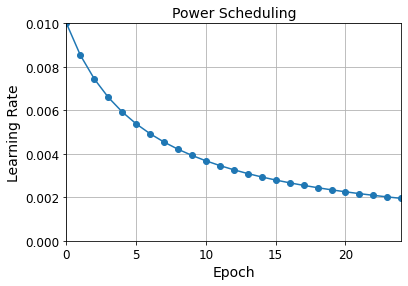

In [16]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

# 거듭제곱 기반 스케줄링의 학습률 그래프 출력
plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Power Scheduling', fontsize=14)
plt.grid(True) # 그리드 격자무늬 출력
plt.show()

### 지수 기반 스케줄링(exponential scheduling)

학습률: `lr = lr0 * 0.1**(epoch / s)`

In [17]:
# 현재 에포크를 받아 학습률을 반환하는 함수를 정의
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [18]:
# 초기 학습률, 스텝 횟수를 위처럼 하드코딩하고 싶지 않다면
# 아래와 같이 이 변수들을 설정한 클로저를 반환하는 함수를 정의
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [19]:
# 옵티마이저에 nadam을 넣은 것 빼곤 앞과 동일
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [20]:
# 위에서 정의한 지수 기반 스케줄링 함수를 전달하여 LearningRateScheduler 콜백 생성
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
n_epochs=25

# 그리고 이 콜백을 fit() 메서드에 전달
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, 
                   validation_data=(X_valid_scaled, y_valid), 
                   callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8432 - accuracy: 0.7577 - val_loss: 0.8951 - val_accuracy: 0.7486 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6839 - accuracy: 0.7933 - val_loss: 0.7768 - val_accuracy: 0.7690 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5941 - accuracy: 0.8164 - val_loss: 0.6023 - val_accuracy: 0.8216 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5489 - accuracy: 0.8340 - val_loss: 0.8057 - val_accuracy: 0.7738 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4838 - accuracy: 0.8475 - val_loss: 0.6224 - val_accuracy: 0.8274 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4535 - accuracy: 0.8569 - val_loss: 0.5165 - val_accuracy: 0.8508 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 6s

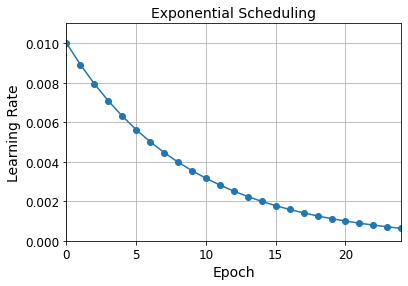

In [21]:
# 지수 기반 스케줄링의 학습률 그래프 출력
plt.plot(history.epoch, history.history['lr'], 'o-')
plt.axis([0, n_epochs-1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

아래의 스케줄 함수는 두 번째 매개변수로 **현재 학습률**을 받을 수 있음:

In [22]:
def exponential_decay_fn(epoch, lr):
    return lr + 0.1**(1 / 20)

에포크가 아니라 **반복마다** 학습률을 업데이트하려면 아래와 같은 **사용자 정의 콜백 클래스**를 작성해야 함:

In [23]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s
    
    def on_batch_begin(self, batch, logs=None):
        # 에포크마다 'batch' 매개변수가 재설정됨
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)


In [24]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# nadam의 학습률을 직접 지정
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
n_epochs = 25
s = 20 * len(X_train) // 32 # 20 epoch 동안의 스텝 횟수(batch_size=32)
exp_decay = ExponentialDecay(s) # 앞서 정의한 사용자 지정 콜백 호출

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7975 - accuracy: 0.7674 - val_loss: 0.7352 - val_accuracy: 0.8100 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7026 - accuracy: 0.7918 - val_loss: 0.7189 - val_accuracy: 0.7734 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5864 - accuracy: 0.8205 - val_loss: 0.7039 - val_accuracy: 0.8140 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5460 - accuracy: 0.8329 - val_loss: 0.5977 - val_accuracy: 0.8416 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4643 - accuracy: 0.8511 - val_loss: 0.5779 - val_accuracy: 0.8418 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4377 - accuracy: 0.8599 - val_loss: 0.4733 - val_accuracy: 0.8664 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 7s

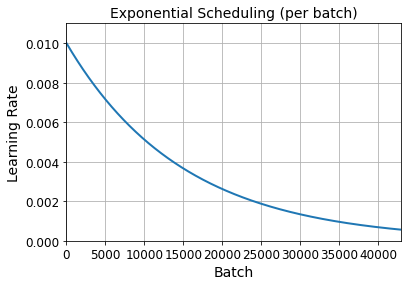

In [26]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

# 반복마다 업데이트한 지수 기반 스케줄링의 학습률 그래프 출력
plt.plot(steps, lrs, '-', linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 구간별 고정 스케줄링(piecewise constant scheduling)

일정 횟수의 에포크 동안 일정한 학습률을 사용하고, 그다음 또 다른 횟수의 에포크 동안 작은 학습률을 사용하는 방식

In [27]:
# 구간별 고정 스케줄링을 위한 스케줄 함수 정의
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [28]:
# 마찬가지로 아래처럼 따로 횟수와 학습률을 넣어주게끔 설계도 가능
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [29]:
# 지수 기반 스케줄링에서 설계한 것과 동일
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [30]:
# 위에서 정의한 구간별 고정 스케줄링 함수를 전달하여 LearningRateScheduler 콜백 생성
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
n_epochs=25

# 그리고 이 콜백을 fit() 메서드에 전달
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, 
                   validation_data=(X_valid_scaled, y_valid), 
                   callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.8255 - accuracy: 0.7608 - val_loss: 0.8349 - val_accuracy: 0.7540 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8640 - accuracy: 0.7464 - val_loss: 0.9273 - val_accuracy: 0.7240 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9321 - accuracy: 0.7277 - val_loss: 1.2761 - val_accuracy: 0.5386 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.9224 - accuracy: 0.6943 - val_loss: 1.0150 - val_accuracy: 0.6848 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 1.0136 - accuracy: 0.6731 - val_loss: 0.8957 - val_accuracy: 0.7058 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6614 - accuracy: 0.7710 - val_loss: 0.7379 - val_accuracy: 0.7916 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

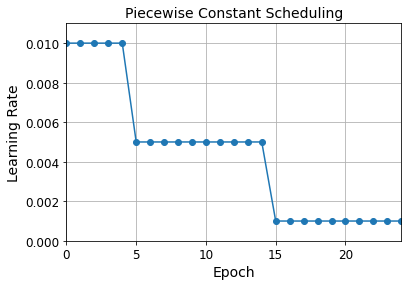

In [31]:
# 구간별 고정 스케줄링의 학습률 그래프 출력
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], 'o-')
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 성능 기반 스케줄링(performance scheduling)

매 N 스텝마다 **마치 조기 종료처럼** 검증 오차를 측정하고 **오차가 줄어들지 않으면 $\lambda$배만큼 학습률을 감소**시키는 방식

In [32]:
# 랜덤 시드 42로 고정
tf.random.set_seed(42)
np.random.seed(42)

# 모델은 옵티마이저 부분만 모멘텀 최적화로 변경됨
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [33]:
# 성능 기반 스케줄링을 위해서는 ReduceLROnPlateau 콜백을 사용함
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5967 - accuracy: 0.8036 - val_loss: 0.4901 - val_accuracy: 0.8494 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4936 - accuracy: 0.8408 - val_loss: 0.5468 - val_accuracy: 0.8420 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5204 - accuracy: 0.8400 - val_loss: 0.5637 - val_accuracy: 0.8464 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5029 - accuracy: 0.8489 - val_loss: 0.5661 - val_accuracy: 0.8398 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5302 - accuracy: 0.8470 - val_loss: 0.5788 - val_accuracy: 0.8350 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5224 - accuracy: 0.8534 - val_loss: 0.6985 - val_accuracy: 0.8416 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 5s

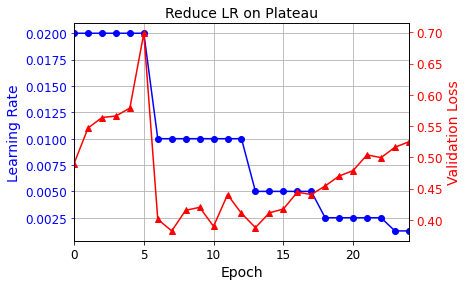

In [34]:
# 성능 기반 스케줄링의 학습률 그래프 출력
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras 스케줄러(tf.keras.optimizers.schedules)

`keras.optimizers.schedules`에 있는 스케줄 중에 하나를 사용해 학습률을 정의하고 이 학습률을 옵티마이저에 전달하여 매 스텝마다 학습률을 업데이트하는 방식

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # 20번의 epoch 동안의 스텝 수(batch_size=32)

# 이 부분이 바로 tf.keras 스케줄러를 설정하는 부분!
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
# 설정한 스케줄러의 학습률을 SGD 옵티마이저에 지정
optimizer = keras.optimizers.SGD(learning_rate)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [36]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4908 - accuracy: 0.8273 - val_loss: 0.4052 - val_accuracy: 0.8584
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3789 - accuracy: 0.8655 - val_loss: 0.3731 - val_accuracy: 0.8706
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3443 - accuracy: 0.8781 - val_loss: 0.3742 - val_accuracy: 0.8690
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3221 - accuracy: 0.8854 - val_loss: 0.3502 - val_accuracy: 0.8778
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3064 - accuracy: 0.8907 - val_loss: 0.3441 - val_accuracy: 0.8780
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2925 - accuracy: 0.8953 - val_loss: 0.3410 - val_accuracy: 0.8774
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2823 - accuracy: 0.8995 - val_loss: 0.3361 - val_accuracy:

`keras.optimizers.schedules`에는 다음과 같이 구간별 고정 스케줄링 방식도 제공하고 있음:

In [37]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

아래 코드는 1사이클 스케줄링에 들어있었는데, 내용은 **지수 기반 스케줄링**으로 보여 이곳에 작성함:

In [38]:
K = keras.backend

# 이 부분은 경고에 있던 수정된 클래스로 바로 작성함
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs['loss'] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs['loss']
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor) # 앞서 작성한 클래스 호출
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                       callbacks=[exp_lr]) # 콜백에 사용자 정의 학습률 적용
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.3815


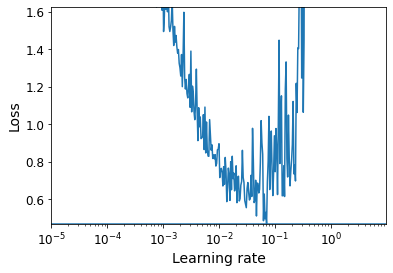

In [40]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

### 1사이클 스케줄링

훈련 절반 동안 초기 학습률을 선형적으로 최대 학습률까지 증가시킨 뒤, 나머지 절반 동안 선형적으로 학습률을 초기 학습률까지 다시 줄이고 마지막 몇 번의 에포크는 학습률을 소수점 몇 째 자리까지 줄이는 방식  

많은 실험을 통해 이 방식이 **훈련 속도를 크게 늘려주고 더 높은 성능을 낸다**는 것을 보였다고 함

In [41]:
# 1사이클 스케줄링을 위한 클래스 정의
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, 
                last_iterations=None, last_rate=None):
        # 아래처럼 모든 것을 직접 지정함
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) 
               / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, 
                                    self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                    self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [42]:
# 1사이클 스케줄링을 위해 앞에서 정의한 클래스를 가져와 콜백으로 사용
onecycle=OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
n_epochs=25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 0.6582 - accuracy: 0.7693 - val_loss: 0.4793 - val_accuracy: 0.8356
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4520 - accuracy: 0.8420 - val_loss: 0.4235 - val_accuracy: 0.8502
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4068 - accuracy: 0.8574 - val_loss: 0.4091 - val_accuracy: 0.8578
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3782 - accuracy: 0.8667 - val_loss: 0.3858 - val_accuracy: 0.8658
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3576 - accuracy: 0.8743 - val_loss: 0.3685 - val_accuracy: 0.8710
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3386 - accuracy: 0.8801 - val_loss: 0.3629 - val_accuracy: 0.8746
Epoch 7/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3254 - accuracy: 0.8846 - val_loss: 0.3558 - val_accuracy: 0.8770
Epoch 

# 11.4 규제를 사용해 과대적합 피하기

심층 신경망 네트워크의 높은 자유도는  대규모의 복잡한 데이터셋을 학습할 수 있지만, 이 높은 자유도가 네트워크를 훈련 세트에 과대적합되기 쉽게 만듦  

따라서 다음과 같은 적절한 규제들이 필요함:

## 11.4.1 L1과 L2 규제

- **L1 규제**: 손실 함수에 가중치의 절대값인 L1 norm을 더하는 규제
- **L2 규제**: 손실 함수에 가중치에 대한 L2 norm의 제곱을 더하는 규제

패션 MNIST 데이터 다시 로드

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [24]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# l1 규제를 적용하고 싶다면 keras.regularizers.l1(0.01) 이런식으로 하면 됨
# l1,l2 규제를 둘다 적용하려면 tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01) 이런식으로 하면 됨

In [25]:
# 규제를 가한 모델 쌓기
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)), # l2 규제 적용 모습
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)), # l2 규제 적용 모습
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01)) # l2 규제 적용 모습
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 1.5971 - accuracy: 0.8117 - val_loss: 0.7199 - val_accuracy: 0.8306
Epoch 2/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7159 - accuracy: 0.8287 - val_loss: 0.6780 - val_accuracy: 0.8392


In [26]:
from functools import partial

# 모델 쌓을 때 코드를 좀더 깔끔하게 보기 위한 방법
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300), # l2 규제 적용
    RegularizedDense(100), # l2 규제 적용
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 1.6640 - accuracy: 0.8137 - val_loss: 0.7191 - val_accuracy: 0.8326
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7186 - accuracy: 0.8281 - val_loss: 0.6829 - val_accuracy: 0.8394


## 11.4.2 드롭아웃

심층 신경망에서 가장 인기 있는 규제 기법 중 하나  

매 훈련 스텝에서 각 뉴런은 임시적으로 드롭아웃(제외)될 확률 p를 가지기 때문에 어떤 훈련에서는 포함되기도 하고, 어떤 훈련에서는 제외되기도 하는 식으로 규제를 가하는 방법  

드롭아웃으로 훈련된 뉴런은 이웃한 뉴런에 맞추어 적응될 수 없기 때문에 가능한 한 자기 자신이 유용해져야 하고, 이런 뉴런들은 몇 개의 입력 뉴런에만 지나치게 의존할 수 없기 때문에 모든 입력 뉴런에 주의를 기울여야 함  
이 과정에서 입력값의 작은 변화에 덜 민감한 뉴런이 만들어 지게 되고 결국 더 안정적인 네트워크가 되어 일반화 성능이 좋아진다고 함

In [7]:
# 규제를 가한 모델 쌓기
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), # 드롭아웃 적용 모습
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2), # 드롭아웃 적용 모습
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2), # 드롭아웃 적용 모습
    keras.layers.Dense(10, activation="softmax")
])
# 주의! 일반적으로 (출력층을 제외한) 맨 위의 층부터 세 번째 층까지 있는 뉴런에만 
# 드롭아웃을 적용

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 0.5706 - accuracy: 0.8031 - val_loss: 0.3740 - val_accuracy: 0.8674
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4200 - accuracy: 0.8480 - val_loss: 0.3463 - val_accuracy: 0.8734


위 코드에서 activation=’selu’를 사용할 때는  `keras.layers.AlphaDropout(rate=0.2)`으로 **알파 드롭아웃**을 사용하면 됨:

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

# 규제를 가한 모델 쌓기
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6661 - accuracy: 0.7593 - val_loss: 0.5785 - val_accuracy: 0.8416
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5552 - accuracy: 0.7948 - val_loss: 0.5597 - val_accuracy: 0.8444
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5293 - accuracy: 0.8035 - val_loss: 0.5035 - val_accuracy: 0.8526
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5093 - accuracy: 0.8111 - val_loss: 0.4468 - val_accuracy: 0.8666
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4894 - accuracy: 0.8178 - val_loss: 0.4458 - val_accuracy: 0.8648
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4819 - accuracy: 0.8216 - val_loss: 0.4778 - val_accuracy: 0.8630
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4673 - accuracy: 0.8269 - val_loss: 0.5274 - val_accuracy:

In [9]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4409 - accuracy: 0.8646


[0.44094380736351013, 0.8646000027656555]

## 11.4.3 몬테 카를로 드롭아웃(MC 드롭아웃)

드롭아웃의 한 종류로, 드롭아웃 모델의 성능을 높여주고, 더 정확한 불확실성 추정을 제공하는 기술

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [11]:
# 드롭아웃 없이 첫 번째 샘플을 모델이 예측한 결과
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 108ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.93]],
      dtype=float32)

In [12]:
# 드롭아웃을 활성화하여 만든 예측 결과
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.37, 0.  , 0.33, 0.  , 0.3 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.34, 0.  , 0.61]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.63, 0.  , 0.37]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.23, 0.  , 0.68]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.61, 0.  , 0.26]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  , 0.85]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.78, 0.  , 0.05, 0.  , 0.17]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.94, 0.  , 0.06]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.73, 0.  , 0.27]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.6 , 0.  , 0.32]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.06, 0.  , 0

In [13]:
# 위 드롭아웃 예측을 첫 번째 차원으로 평균 낸 결과
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.33, 0.  , 0.56]],
      dtype=float32)

드롭아웃을 가하지 않은 예측 결과에 비해 평균 낸 결과가 훨씬 더 낮은 확률로 예측을 하고 있음  
특히 클래스 5(샌들)이나 7(스니커즈)로 생각하는 비율이 각각 11%, 33%로 나타나고 있음

In [14]:
# 위 확률 추정의 표준 분포를 확인한 결과
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.27, 0.  , 0.3 ]],
      dtype=float32)

In [15]:
# 드롭아웃 예측을 한 모델의 정확도
y_pred = np.argmax(y_proba, axis=1)

accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8656

모델이 훈련하는 동안 다르게 작용하는(ex. BatchNormalization 층) 층을 가지고 있다면 다음과 같이 Dropout 층을 MCDropout 클래스로 바꿔주어야 함:

In [16]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

# 몬테 카를로 드롭아웃을 적용
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [18]:
mc_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_8 (Dense)             (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_9 (Dense)             (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)             

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [20]:
# 이전 모델의 가중치로 몬테 카를로 적용 모델의 가중치 적용
mc_model.set_weights(model.get_weights())

이렇게 하면 몬테 카를로 드롭아웃을 모델에 사용할 수 있음:

In [21]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 20ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.32, 0.  , 0.58]],
      dtype=float32)

## 11.4.4 맥스-노름 규제

신경망에서 널리 사용되는 또 다른 규제 기법  

맥스-노름 규제는 배치 정규화를 사용하지 않았을 때 불안정한 그레이디언트 문제를 완화하는 데 도움을 줄 수 있다고 함

In [27]:
# 맥스-노름 규제 층 생성
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [28]:
from functools import partial

# 맨 처음 l2 규제에서처럼 아래와 같이 따로 규제 층을 정의하는 것이 좋음
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

# 규제를 적용한 모델 쌓기
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300), # 맥스-노름 규제 적용
    MaxNormDense(100), # 맥스-노름 규제 적용
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4739 - accuracy: 0.8337 - val_loss: 0.3677 - val_accuracy: 0.8666
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3520 - accuracy: 0.8719 - val_loss: 0.3723 - val_accuracy: 0.8648


# 11.6 연습문제

## 연습문제 8번

### a.  
문제: 100개의 뉴런을 가진 은닉층 20개로 심층 신경망을 만들어보세요(너무 많은 것 같지만 이 연습문제의 핵심입니다). He 초기화와 ELU 활성화 함수를 사용하세요.

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                activation='elu',
                                kernel_initializer='he_normal'))

### b.
문제: Nadam 옵티마이저와 조기 종료를 사용하여 CIFAR10 데이터셋에 이 네트워크를 훈련하세요.  
`keras.datasets.cifar10.load_ data()`를 사용하여 데이터를 적재할 수 있습니다. 이 데이터셋은 10개의 클래스와 32×32 크기의 컬러 이미지 60,000개로 구성됩니다(50,000개는 훈련, 10,000개는 테스트). 따라서 10개의 뉴런과 소프트맥스 활성화 함수를 사용하는 출력층이 필요합니다.  
모델 구조와 하이퍼파라미터를 바꿀 때마다 적절한 학습률을 찾아야 한다는 것을 기억하세요.

In [30]:
# 모델에 출력층을 추가
model.add(keras.layers.Dense(10, activation='softmax'))

In [32]:
# Nadam 옵티마이저, 학습률 5e-5 사용
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [33]:
# CIFAR10 데이터셋 로드
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

# 원본 훈련 세트의 처음 5000개를 검증 세트로 사용
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170498071/170498071 [==============================] - 138s 1us/step


In [34]:
# 콜백을 만들고 모델을 훈련
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_cifar10_model.h5', save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증기시킬 예정
run_logdir = os.path.join(os.curdir, 'my_cifar10_logs', 'run_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [36]:
# 모델 훈련
model.fit(X_train, y_train, epochs=100,
         validation_data=[X_valid, y_valid], 
         callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 20s 11ms/step - loss: 3.5644 - accuracy: 0.1705 - val_loss: 2.1172 - val_accuracy: 0.2182
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 2.0287 - accuracy: 0.2487 - val_loss: 1.9987 - val_accuracy: 0.2602
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.9193 - accuracy: 0.2926 - val_loss: 1.8904 - val_accuracy: 0.2912
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8505 - accuracy: 0.3194 - val_loss: 1.8774 - val_accuracy: 0.3206
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7910 - accuracy: 0.3483 - val_loss: 1.7767 - val_accuracy: 0.3504
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.7423 - accuracy: 0.3722 - val_loss: 1.7148 - val_accuracy: 0.3702
Epoch 7/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6953 - accuracy: 0.3882 - val_loss: 1

1407/1407 [==============================] - 16s 11ms/step - loss: 1.1287 - accuracy: 0.5934 - val_loss: 1.5603 - val_accuracy: 0.4706
Epoch 57/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.1177 - accuracy: 0.5991 - val_loss: 1.5550 - val_accuracy: 0.4832
Epoch 58/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.1136 - accuracy: 0.5969 - val_loss: 1.5712 - val_accuracy: 0.4736
Epoch 59/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.1077 - accuracy: 0.5990 - val_loss: 1.5497 - val_accuracy: 0.4768
Epoch 60/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.0996 - accuracy: 0.6023 - val_loss: 1.5654 - val_accuracy: 0.4748
Epoch 61/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.0923 - accuracy: 0.6072 - val_loss: 1.5648 - val_accuracy: 0.4742
Epoch 62/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.0907 - accuracy: 0.6053 - val_loss: 1.5799 

In [37]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

Reusing TensorBoard on port 6006 (pid 9676), started 2:05:51 ago. (Use '!kill 9676' to kill it.)

In [38]:
model = keras.models.load_model('my_cifar10_model.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.5066 - accuracy: 0.4818


[1.5065604448318481, 0.48179998993873596]

### c.
문제: 배치 정규화를 추가하고 학습 곡선을 비교해보세요. 이전보다 빠르게 수렴하나요? 더 좋은 모델이 만들어지나요? 훈련 속도에는 어떤 영향을 미치나요?

다음 코드는 위의 코드와 배우 비슷합니다. 몇 가지 다른 점은 아래와 같습니다:

- 출력층을 제외하고 모든 Dense 층 다음에 (활성화 함수 전에) BN 층을 추가했습니다. 처음 은닉층 전에도 BatchNormalization(BN) 층을 추가했습니다.
- 학습률을 5e-4로 바꾸었습니다. 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3를 시도해 보고 20번 에포크 후에 검증 세트 성능이 가장 좋은 것을 선택했습니다.
- run_logdir를 runbn* 으로 이름을 바꾸고 모델 파일 이름을 my_cifar10_bn_model.h5로 변경했습니다.

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# 배치 정규화 층을 추가하여 모델 다시 쌓기
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# nadam 옵티마이저에 학습률을 5e-4로 직접 설정
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

# 콜백 설정(너무 오래 학습하는거 같아 patience를 10으로 줄임)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_cifar10_bn_model.h5', save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킬 예정
run_logdir = os.path.join(os.curdir, 'my_cifar10_logs', 'run_bn_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
         validation_data=(X_valid, y_valid),
         callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 36s 16ms/step - loss: 1.8324 - accuracy: 0.3420 - val_loss: 1.6355 - val_accuracy: 0.4178
Epoch 2/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.6623 - accuracy: 0.4070 - val_loss: 1.5782 - val_accuracy: 0.4318
Epoch 3/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5985 - accuracy: 0.4324 - val_loss: 1.5371 - val_accuracy: 0.4426
Epoch 4/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5496 - accuracy: 0.4482 - val_loss: 1.5376 - val_accuracy: 0.4582
Epoch 5/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5056 - accuracy: 0.4654 - val_loss: 1.4376 - val_accuracy: 0.4862
Epoch 6/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.4684 - accuracy: 0.4801 - val_loss: 1.4182 - val_accuracy: 0.5028
Epoch 7/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.4331 - accuracy: 0.4910 - val_loss: 1

In [41]:
model = keras.models.load_model('my_cifar10_bn_model.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.3214 - accuracy: 0.5434


[1.3214244842529297, 0.54339998960495]

- 이전보다 빠른 수렴 여부: earlystopping의 patience 20이 너무 크다고 느껴 절반으로 줄여버려서 객관적으로 비교할 순 없지만, 62에포크에서 34에포크로 더 빠르게 수렴하였음
- BN이 더 좋은 모델을 만드는지 여부: 검증 정확도가 48.18%에서 54.34%로 상승하였기 때문에 BN이 더 좋은 모델을 만든다고 볼 수 있음
- BN이 훈련속도에 영향을 주는지 여부: 아무래도 층이 추가되었기 때문에 약 17초에서 27초로 에포크 당 10초 정도가 더 걸렸음

### d.
문제: 배치 정규화를 SELU로 바꾸어보세요. 네트워크가 자기 정규화하기 위해 필요한 변경 사항을 적용해보세요(즉, 입력 특성 표준화, 르쿤 정규분포 초기화, 완전 연결 층만 순차적으로 쌓은 심층 신경망 등).

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# SELU와 자기 정규화를 위한 변경사항을 적용하여 모델 쌓기
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                kernel_initializer='lecun_normal',
                                activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# Nadam의 학습률을 5e-4로 지정
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# 콜백 지정(너무 오래 학습하는거 같아 patience를 10으로 줄임)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킬 예정
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# 입력 특성 표준화 진행
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
         validation_data=(X_valid_scaled, y_valid),
         callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 18s 9ms/step - loss: 1.9080 - accuracy: 0.2571 - val_loss: 1.7959 - val_accuracy: 0.3060
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.7164 - accuracy: 0.3591 - val_loss: 1.6991 - val_accuracy: 0.3632
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.6159 - accuracy: 0.4053 - val_loss: 1.6111 - val_accuracy: 0.4126
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.5459 - accuracy: 0.4358 - val_loss: 1.5881 - val_accuracy: 0.4370
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1.4815 - accuracy: 0.4650 - val_loss: 1.6093 - val_accuracy: 0.4208
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4300 - accuracy: 0.4870 - val_loss: 1.5276 - val_accuracy: 0.4586
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3786 - accuracy: 0.5049 - val_loss: 1.5359

In [43]:
model = keras.models.load_model('my_cifar10_selu_model.h5')
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.4706 - accuracy: 0.4954


[1.4706134796142578, 0.49540001153945923]

검증 정확도가 원래 모델의 48.18%에서 49.54%로 소폭 상승하였음

### e.
문제: 알파 드롭아웃으로 모델에 규제를 적용해보세요. 그다음 모델을 다시 훈련하지 않고 MC 드롭아웃으로 더 높은 정확도를 얻을 수 있는지 확인해보세요.

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# 이 부분은 앞과 동일
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
    
# 알파 드롭아웃 규제 적용
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation='softmax'))

# 옵티마이저도 앞과 동일
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# 콜백도 앞과 동일
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# 입력 데이터 표준화도 앞과 동일
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 21s 10ms/step - loss: 1.8953 - accuracy: 0.3242 - val_loss: 1.7431 - val_accuracy: 0.3900
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6624 - accuracy: 0.4130 - val_loss: 1.7192 - val_accuracy: 0.3868
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5651 - accuracy: 0.4484 - val_loss: 1.6551 - val_accuracy: 0.4308
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5024 - accuracy: 0.4708 - val_loss: 1.5489 - val_accuracy: 0.4542
Epoch 5/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.4406 - accuracy: 0.4954 - val_loss: 1.5890 - val_accuracy: 0.4530
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.3984 - accuracy: 0.5094 - val_loss: 1.5223 - val_accuracy: 0.4878
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3555 - accuracy: 0.5284 - val_loss: 1

In [45]:
model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.5223 - accuracy: 0.4878


[1.5222821235656738, 0.4878000020980835]

검증 정확도가 48.78%로 원래 모델의 검증 정확도 48.18%보다 소폭 상승하였음  

이제 MC 드롭아웃을 위한 준비:

In [46]:
# 앞서 사용한 MCAlphaDropout 클래스를 복사해서 사용
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [47]:
# 방금 훈련했던 모델과 같은 가중치를 가진 새로운 모델을 생성
# AlphaDropout 층이 아닌 MCAlphaDropout 층을 사용
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers # 방금 훈련했던 모델을 가져옴
])

In [48]:
# 몇 가지 유틸리티 함수를 추가
# 첫 번째 함수: 모델을 여러 번 실행(기본 세팅:10번)하여 평균을 낸 예측 클래스 확률을 반환
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)


# 두 번째 함수: 첫 번째 함수에서 구한 평균 확률로 각 샘플의 클래스를 예측
def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [49]:
# 이제 검증 세트의 모든 샘플에 대한 예측 생성 후 정확도 계산
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

157/157 [==============================] - 0s 3ms/step


0.4876

검증 정확도가 48.76%로 이전 48.78%보다 아주 소폭 하락하였음  

따라서 이 연습문제에서 얻은 최상의 모델은 **BatchNormalization 층을 사용한 배치 정규화 모델**임

### f.
문제: 1사이클 스케줄링으로 모델을 다시 훈련하고 훈련 속도와 모델 정확도가 향상되는지 확인해보세요.

In [50]:
# 앞에서 정의한 클래스 다시 가져옴
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [51]:
# 앞에서 정의한 클래스 다시 가져옴
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [52]:
# 앞에서 한 알파 드롭아웃을 적용한 모델 다시 정의
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 5s 12ms/step - loss: nan - accuracy: 0.1420


(9.999999747378752e-06,
 9.615227699279785,
 2.621089458465576,
 4.016006674085345)

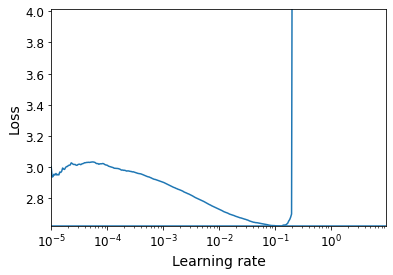

In [54]:
# 1사이클 스케줄링에서 정의한 클래스를 바탕으로 학습률-손실 그래프 작성
import math

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [55]:
# 처음 시작 학습률을 1e-2(10의 -2승)으로 변경하여 다시 모델링
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [56]:
# 15 에포크 만큼 1사이클 스케줄링 콜백을 사용하여 모델 학습
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 6s 14ms/step - loss: 2.0432 - accuracy: 0.2862 - val_loss: 1.7718 - val_accuracy: 0.3662
Epoch 2/15
352/352 [==============================] - 4s 12ms/step - loss: 1.7532 - accuracy: 0.3780 - val_loss: 1.6816 - val_accuracy: 0.4008
Epoch 3/15
352/352 [==============================] - 4s 12ms/step - loss: 1.6243 - accuracy: 0.4215 - val_loss: 1.6018 - val_accuracy: 0.4380
Epoch 4/15
352/352 [==============================] - 4s 12ms/step - loss: 1.5483 - accuracy: 0.4470 - val_loss: 1.6041 - val_accuracy: 0.4400
Epoch 5/15
352/352 [==============================] - 4s 12ms/step - loss: 1.4943 - accuracy: 0.4675 - val_loss: 1.5958 - val_accuracy: 0.4612
Epoch 6/15
352/352 [==============================] - 4s 13ms/step - loss: 1.4527 - accuracy: 0.4855 - val_loss: 1.5376 - val_accuracy: 0.4598
Epoch 7/15
352/352 [==============================] - 4s 12ms/step - loss: 1.4170 - accuracy: 0.4999 - val_loss: 1.6096 - val_accuracy: 0.4520

배치 사이즈가 128로 컸기 때문에 각 에포크는 약 4초 정도씩만 소요되었음  
이는 지금까지 훈련한 가장 빠른 모델보다 약 3배 정도로 굉장히 빠른 편임  
뿐만 아니라 모델의 검증 정확도도 52.38%로 비교의 기준이었던 48.18%보다 올라갔음.  

검증 정확도가 54.34%였던 배치 정규화 모델보다는 1 사이클 스케줄링 모델이 성능이 낮지만, 그래도 훈련 속도가 에포크당 27초에서 4초로 훨씬 더 줄어들었기 때문에 고려해볼만 한 선택지이라고 볼 수 있음 

# END